# EfficientNet for Image Classification

In [ ]:
# imports
import pandas as pd
import numpy as np
import torch
import time
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
import timeit
import torchvision
# import torchsummary
from torchvision import transforms, datasets
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
# from torchsummary import summary
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns

# to save session
import pickle

from tqdm import tqdm

In [ ]:
# Training for one epoch

def train_model(model, criterion, optimizer, train_loader, val_loader):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for epoch in range(1):  # Loop over one epoch only
        # Create a progress bar for the entire training process
        progress_bar = tqdm(total=len(train_loader), desc=f"Training", position=0)

        for images, labels in train_loader:
            labels = labels.long()
            labels = labels.to(device)
            images = images.to(device)
            optimizer.zero_grad()
            # forward propagation, i.e. get predictions
            outputs = model(images)
            # calculate loss and backpropagate to model paramters:
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            # Update the progress bar
            progress_bar.update(1)
            # progress_bar.set_postfix({'train_loss': train_loss / total_train})

    train_loss /= len(train_loader.dataset)
    train_acc = correct_train / total_train

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            labels=labels.long()
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc = correct_val / total_val

    progress_bar.close()

    return train_loss, val_loss, train_acc, val_acc

In [ ]:
print("PyTorch version:")
print(torch.__version__)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using {} device".format(device))

PyTorch version:
2.2.1+cu121
Using cuda device


### Define paths
(comment out whichever not in use)

In [ ]:
# ## FOR JUPYTER
# metadata_path = 'data/encoded_final_data.csv'
# images_path = 'processed_images'

In [ ]:
## FOR GOOGLE COLAB
# paths
metadata_path = '/content/drive/MyDrive/CDS Project/data/encoded_final_data.csv'
images_path = '/content/drive/MyDrive/CDS Project/directly_processed_images'

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
metadata_df = pd.read_csv(metadata_path)
metadata_df

,image_id,age,head/neck,lower extremity,oral/genital,palms/soles,torso,upper extremity,female,male,target
0,ISIC_5136612,65.0,0,False,False,0,1,False,False,True,0
1,ISIC_0031002,65.0,0,False,False,0,0,True,False,True,0
2,ISIC_0026875,35.0,0,False,False,0,0,True,True,False,1
3,ISIC_0024371,70.0,0,True,False,0,0,False,False,True,2
4,ISIC_0027263,85.0,0,False,False,0,1,False,False,True,3
...,...,...,...,...,...,...,...,...,...,...,...
1395,ISIC_0027531,65.0,0,True,False,0,0,False,False,True,5
1396,ISIC_0025691,50.0,0,False,False,0,1,False,True,False,5
1397,ISIC_0028381,55.0,1,False,False,0,0,False,True,False,6
1398,ISIC_0033254,15.0,0,False,False,0,1,False,False,True,4


In [ ]:
images_path = "/content/drive/MyDrive/CDS Project/directly_processed_images"

### Train test split

In [ ]:
# # Split data in features and target:
# X = metadata_df.drop(['target'], axis=1)  # features
# y = metadata_df['target']  # target

X = metadata_df

# Splitting into train, test and validation sets
# 80% for training
X_train, X_temp = train_test_split(X, test_size=0.2, random_state=0)
# 10% for validation/testing each
X_val, X_test = train_test_split(X_temp, test_size=0.5, random_state=0)

In [ ]:
# Resizing to 224x224, some transformations/augmentation (not sure if appropriate)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### Define CustomDataset

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, metadata, transform=None):
        self.metadata = metadata
        self.images_path = images_path
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        img_id = self.metadata.iloc[idx, 0]  # Get image ID of sample using the metadata index
        img_name = os.path.join(self.images_path, f'processed_{img_id}.jpg')  # Adjusted image path
        if not os.path.exists(img_name):
            raise FileNotFoundError(f"Image file not found: {img_name}")

        image = Image.open(img_name)
        row = metadata_df[metadata_df['image_id'] == img_id]
        label = row.iloc[0]['target']

        if self.transform:
            image = self.transform(image)

        # # extract demographic features
        # age = torch.tensor(self.metadata.iloc[idx, 1])
        # localization = torch.tensor(self.metadata.iloc[idx, 3])
        # gender = torch.tensor(self.metadata.iloc[idx, 4])

        return image, label

Random Sample Index: 1395
Image Shape: torch.Size([3, 224, 224])
Label: 5
<class 'numpy.int64'>


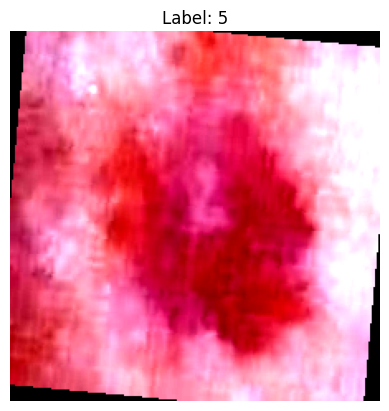

In [ ]:
#test
index = 1395

# Create an instance of CustomDataset
custom_dataset = CustomDataset(metadata=metadata_df, transform=transform)

# Retrieve the image and label using __getitem__
image, label = custom_dataset[index]

# Display information about the sample
print("Random Sample Index:", index)
print("Image Shape:", image.shape)
print("Label:", label)
print(type(label))

# Display the image
plt.imshow(image.permute(1, 2, 0))  # permute to rearrange dimensions from CxHxW to HxWxC
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

In [ ]:
# visualisation
def plotResults():
    plt.figure(figsize=(10,6))
    epovec=range(len(ta))
    plt.plot(epovec,ta,epovec,tl,epovec,va,epovec,vl,linewidth=3)
    plt.legend(('Train_acc','Train_loss','Val_acc','Val_loss'))

    # make the graph understandable:
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.show()

In [ ]:
# evaluate model
def evaluate_model(model, criterion, data_loader):
    model.eval()
    loss = 0.0
    correct = 0
    total = 0

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.long()
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss += criterion(outputs, labels).item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    loss /= len(data_loader.dataset)
    accuracy = correct / total

    return loss, accuracy, all_predictions, all_labels

### Define train, validation and test datasets/loaders (use throughout all models)

In [ ]:
# custom datasets
train_dataset = CustomDataset(metadata=X_train, transform=transform)
val_dataset = CustomDataset(metadata=X_val, transform=transform)
test_dataset = CustomDataset(metadata=X_test, transform=transform)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## 2) Using EfficientNet

In [ ]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 64.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 65.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 98.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 7

In [ ]:
from efficientnet_pytorch import EfficientNet

# Choose the desired EfficientNet variant and size (e.g., 'efficientnet-b0')
model_efficientnet = EfficientNet.from_pretrained('efficientnet-b0')

# Print the EfficientNet model architecture
print(model_efficientnet)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

  0%|          | 0.00/20.4M [00:00<?, ?B/s]
100%|██████████| 20.4M/20.4M [00:00<00:00, 149MB/s]

Loaded pretrained weights for efficientnet-b0
EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kern

In [ ]:
# same; modifying last layer
num_features = model_efficientnet._fc.in_features
model_efficientnet._fc = nn.Linear(num_features, 7)

# same optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_efficientnet.parameters(), lr=0.001)

model_efficientnet # new model structure

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

In [ ]:
model_efficientnet.to(device)
criterion.to(device)

CrossEntropyLoss()

### Training & visualisation

In [ ]:
# using same training function

# specify epochs to train
total_epochs = 30

tl = []
vl = []
ta = []
va = []

for epoch in range(total_epochs):
    start_time = time.time()  # Record start time

    train_loss, val_loss, train_acc, val_acc = train_model(model_efficientnet, criterion, optimizer, train_loader, val_loader)
    tl.append(train_loss)
    vl.append(val_loss)
    ta.append(train_acc)
    va.append(val_acc)

    elapsed_time = time.time() - start_time  # Calculate elapsed time

    print(f"Epoch {epoch+1}/{total_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Elapsed Time: {elapsed_time:.2f} seconds")

Training: 100%|██████████| 35/35 [00:17<00:00,  2.02it/s]


Epoch 1/30, Train Loss: 1.3736, Train Acc: 0.4795, Val Loss: 2.8560, Val Acc: 0.3000, Elapsed Time: 17.30 seconds


Training: 100%|██████████| 35/35 [00:16<00:00,  2.16it/s]


Epoch 2/30, Train Loss: 0.9479, Train Acc: 0.6562, Val Loss: 1.6216, Val Acc: 0.4786, Elapsed Time: 16.24 seconds


Training: 100%|██████████| 35/35 [00:16<00:00,  2.09it/s]


Epoch 3/30, Train Loss: 0.7818, Train Acc: 0.7250, Val Loss: 1.7236, Val Acc: 0.4786, Elapsed Time: 16.76 seconds


Training: 100%|██████████| 35/35 [00:16<00:00,  2.15it/s]


Epoch 4/30, Train Loss: 0.5429, Train Acc: 0.8134, Val Loss: 1.8855, Val Acc: 0.5571, Elapsed Time: 16.31 seconds


Training: 100%|██████████| 35/35 [00:16<00:00,  2.10it/s]


Epoch 5/30, Train Loss: 0.4430, Train Acc: 0.8446, Val Loss: 2.2549, Val Acc: 0.5357, Elapsed Time: 16.67 seconds


Training: 100%|██████████| 35/35 [00:16<00:00,  2.14it/s]


Epoch 6/30, Train Loss: 0.3542, Train Acc: 0.8714, Val Loss: 2.5732, Val Acc: 0.6071, Elapsed Time: 16.34 seconds


Training: 100%|██████████| 35/35 [00:16<00:00,  2.15it/s]


Epoch 7/30, Train Loss: 0.3556, Train Acc: 0.8786, Val Loss: 1.6797, Val Acc: 0.6214, Elapsed Time: 16.33 seconds


Training: 100%|██████████| 35/35 [00:16<00:00,  2.14it/s]


Epoch 8/30, Train Loss: 0.3233, Train Acc: 0.8911, Val Loss: 1.8179, Val Acc: 0.5643, Elapsed Time: 16.37 seconds


Training: 100%|██████████| 35/35 [00:16<00:00,  2.14it/s]


Epoch 9/30, Train Loss: 0.2797, Train Acc: 0.9080, Val Loss: 2.2281, Val Acc: 0.6214, Elapsed Time: 16.35 seconds


Training: 100%|██████████| 35/35 [00:16<00:00,  2.17it/s]


Epoch 10/30, Train Loss: 0.2033, Train Acc: 0.9339, Val Loss: 1.4707, Val Acc: 0.6643, Elapsed Time: 16.15 seconds


Training: 100%|██████████| 35/35 [00:15<00:00,  2.19it/s]


Epoch 11/30, Train Loss: 0.1453, Train Acc: 0.9580, Val Loss: 1.5677, Val Acc: 0.6929, Elapsed Time: 16.00 seconds


Training: 100%|██████████| 35/35 [00:16<00:00,  2.18it/s]


Epoch 12/30, Train Loss: 0.1284, Train Acc: 0.9589, Val Loss: 1.4415, Val Acc: 0.6429, Elapsed Time: 16.04 seconds


Training: 100%|██████████| 35/35 [00:16<00:00,  2.15it/s]


Epoch 13/30, Train Loss: 0.1705, Train Acc: 0.9411, Val Loss: 1.3973, Val Acc: 0.6643, Elapsed Time: 16.30 seconds


Training: 100%|██████████| 35/35 [00:15<00:00,  2.20it/s]


Epoch 14/30, Train Loss: 0.1293, Train Acc: 0.9580, Val Loss: 1.5015, Val Acc: 0.6571, Elapsed Time: 15.92 seconds


Training: 100%|██████████| 35/35 [00:15<00:00,  2.19it/s]


Epoch 15/30, Train Loss: 0.1261, Train Acc: 0.9661, Val Loss: 1.5563, Val Acc: 0.6571, Elapsed Time: 15.97 seconds


Training: 100%|██████████| 35/35 [00:15<00:00,  2.20it/s]


Epoch 16/30, Train Loss: 0.1038, Train Acc: 0.9679, Val Loss: 1.4530, Val Acc: 0.6929, Elapsed Time: 15.90 seconds


Training: 100%|██████████| 35/35 [00:16<00:00,  2.14it/s]


Epoch 17/30, Train Loss: 0.0987, Train Acc: 0.9634, Val Loss: 1.4579, Val Acc: 0.7000, Elapsed Time: 16.38 seconds


Training: 100%|██████████| 35/35 [00:15<00:00,  2.21it/s]


Epoch 18/30, Train Loss: 0.1370, Train Acc: 0.9571, Val Loss: 1.9380, Val Acc: 0.6357, Elapsed Time: 15.83 seconds


Training: 100%|██████████| 35/35 [00:15<00:00,  2.19it/s]


Epoch 19/30, Train Loss: 0.1168, Train Acc: 0.9607, Val Loss: 1.5337, Val Acc: 0.6571, Elapsed Time: 15.97 seconds


Training: 100%|██████████| 35/35 [00:16<00:00,  2.17it/s]


Epoch 20/30, Train Loss: 0.1000, Train Acc: 0.9643, Val Loss: 1.8378, Val Acc: 0.6786, Elapsed Time: 16.11 seconds


Training: 100%|██████████| 35/35 [00:16<00:00,  2.14it/s]


Epoch 21/30, Train Loss: 0.1156, Train Acc: 0.9580, Val Loss: 1.6133, Val Acc: 0.6929, Elapsed Time: 16.38 seconds


Training: 100%|██████████| 35/35 [00:16<00:00,  2.18it/s]


Epoch 22/30, Train Loss: 0.1257, Train Acc: 0.9643, Val Loss: 1.7784, Val Acc: 0.6786, Elapsed Time: 16.09 seconds


Training: 100%|██████████| 35/35 [00:15<00:00,  2.19it/s]


Epoch 23/30, Train Loss: 0.1591, Train Acc: 0.9527, Val Loss: 1.8426, Val Acc: 0.6714, Elapsed Time: 15.96 seconds


Training: 100%|██████████| 35/35 [00:16<00:00,  2.18it/s]


Epoch 24/30, Train Loss: 0.1051, Train Acc: 0.9616, Val Loss: 2.0505, Val Acc: 0.5929, Elapsed Time: 16.05 seconds


Training: 100%|██████████| 35/35 [00:16<00:00,  2.15it/s]


Epoch 25/30, Train Loss: 0.0815, Train Acc: 0.9759, Val Loss: 1.5196, Val Acc: 0.6714, Elapsed Time: 16.26 seconds


Training: 100%|██████████| 35/35 [00:16<00:00,  2.16it/s]


Epoch 26/30, Train Loss: 0.0957, Train Acc: 0.9705, Val Loss: 2.2296, Val Acc: 0.6214, Elapsed Time: 16.24 seconds


Training: 100%|██████████| 35/35 [00:16<00:00,  2.17it/s]


Epoch 27/30, Train Loss: 0.1047, Train Acc: 0.9652, Val Loss: 1.5407, Val Acc: 0.7071, Elapsed Time: 16.15 seconds


Training: 100%|██████████| 35/35 [00:16<00:00,  2.18it/s]


Epoch 28/30, Train Loss: 0.0802, Train Acc: 0.9786, Val Loss: 1.2795, Val Acc: 0.7071, Elapsed Time: 16.07 seconds


Training: 100%|██████████| 35/35 [00:16<00:00,  2.12it/s]


Epoch 29/30, Train Loss: 0.0652, Train Acc: 0.9768, Val Loss: 1.8173, Val Acc: 0.6643, Elapsed Time: 16.51 seconds


Training: 100%|██████████| 35/35 [00:16<00:00,  2.16it/s]

Epoch 30/30, Train Loss: 0.0783, Train Acc: 0.9777, Val Loss: 1.8662, Val Acc: 0.7000, Elapsed Time: 16.20 seconds


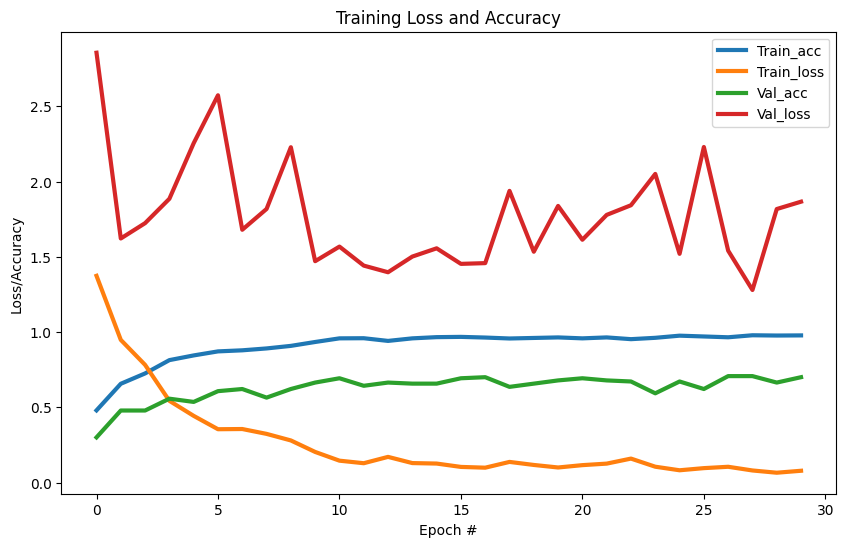

Test Loss: 1.5211773804255895
Test Accuracy: 0.7285714285714285


In [ ]:
plotResults()
test_loss, test_accuracy, pred, lab = evaluate_model(model_efficientnet, criterion, test_loader)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Evaluate model
test_loss, test_accuracy, all_predictions, all_labels = evaluate_model(model_efficientnet, criterion, test_loader)

# Compute classification report
report = classification_report(all_labels, all_predictions)
print("Classification Report:\n", report)

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:\n", conf_matrix)

# Compute accuracy per class
class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
print("Accuracy per Class:", class_accuracy)

print("Test Loss: ", test_loss)
print("Test Accuacy: ", test_accuracy)

Classification Report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89        16
           1       0.83      0.90      0.86        21
           2       0.59      0.67      0.62        15
           3       0.55      0.80      0.65        15
           4       0.96      0.92      0.94        24
           5       0.74      0.78      0.76        18
           6       1.00      0.52      0.68        31

    accuracy                           0.78       140
   macro avg       0.78      0.80      0.77       140
weighted avg       0.82      0.78      0.78       140

Confusion Matrix:
 [[16  0  0  0  0  0  0]
 [ 0 19  0  2  0  0  0]
 [ 1  2 10  1  0  1  0]
 [ 0  1  1 12  0  1  0]
 [ 1  1  0  0 22  0  0]
 [ 2  0  1  0  1 14  0]
 [ 0  0  5  7  0  3 16]]
Accuracy per Class: [1.         0.9047619  0.66666667 0.8        0.91666667 0.77777778
 0.51612903]
Test Loss:  1.3012902055467879
Test Accuacy:  0.7785714285714286


### Save efficient model

In [ ]:
## Save model architecture + learned parameters
# save model using torch
torch.save(model_efficientnet, '/content/drive/MyDrive/CDS Project/saved_models/efficentnet.pth')
torch.save(model_efficientnet.state_dict(), '/content/drive/MyDrive/CDS Project/saved_models/efficentnet_params.pth')